# Kaggle challenge: Airbnb - New User Bookings
# Data exploration

This notebook documents exploratory analyses of the data sets used for the Kaggle "Airbnb -New User Bookings" competition. Distributions of each variable are plotted and missing values are identified.

See the [Kaggle announcement](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) for details about the challenge.  See [my blog post](https://purcelba.github.io/Kaggle-airbnb/) for a summary of my analysis and modeling. A notebook that implements the modeling can be found [here](https://github.com/purcelba/kaggle_airbnb_new_user_booking/blob/master/notebooks/airbnb_models.ipynbSee). 

## Instructions

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. __You are asked to predict which country a new user's first booking destination will be.__ All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. 'NDF' is different from 'other' because 'other' means there was a booking to a country not listed above, but 'NDF' means there was no booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014.  In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

## Data

The data are available for download [here](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data).
The core data files are the following:
- train_users_2.csv - the training set of user inforation with country destination provided (6/28/10 - 6/30/14)
- test_users.csv - the test set of user information with country destination to be predicted (7/1/14 - 9/30/14)

# Data overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns
%matplotlib inline

Load the data and report summary statistics.

In [3]:
data_path = '../data/'
df_train = pd.read_csv(data_path + 'train_users_2.csv')            #load training data
df_test = pd.read_csv(data_path + 'test_users.csv')                #load testing data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True) #combine train/test for convenience later

Print some summary statistics

In [4]:
print("%d users in the training set." % df_train.shape[0])
print("%d users in the test set." % df_test.shape[0])
n_users = df_train.shape[0] + df_test.shape[0]
print("%d total users." % n_users)

213451 users in the training set.
62096 users in the test set.
275547 total users.


Data preview

In [5]:
df_train.iloc[0:5,[0,1,2,3,4,5,8,15]]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,language,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,en,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,en,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,en,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,en,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,en,US


## Data processing functions

Define a set of functions to provide useful summary statistics and plots for variable in the data set.  Descriptions are provided in the docstrings.

In [9]:
def cate_hist(df, col_name):
    """
    This function will generate a simple formatted histogram of counts for any 
    column of a DataFrame with categorical entries.
    
    Args:
        df (DataFrame): the dataframe from which data will be plotted
        col_name (str): the name of the DataFrame column to be plotted
        
    Returns:
        categories: the list of categories in the dataframe column.
        counts: the number of occurences of that category
    """
        #get list of category labels and count
    categories = pd.unique(df[col_name].ravel())
    count = [np.sum(df[col_name]==x) for x in categories]
        #generate the histogram
    fig = plt.figure()
    ax = fig.add_axes([.2,.6,1,.4])
    
    x = np.arange(len(categories))
    y = count
    width = 1.0
    ax.bar(x,y,width,color='r')
        #label the histogram
    ax.set_xlabel(col_name)
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels((categories))
    plt.tick_params(direction = 'out')
    plt.xticks(rotation = 90)
    
    return categories, count

def cate_prop_se(df, col_name, categories = None):
    """
    Given some DataFrame and column name, for each unique element in the column, 
    compute the proportion and standard error.    

    Args:
        df (DataFrame):               the dataframe from which data will be plotted
        col_name (str):               the name of the DataFrame column to be plotted
        categories (array, optional): if provided, defines the categories to use, filling in NaNs if
                                      a category is not found.  If not provided, then will infer categories
                                      from df.
        
    Returns:
        categories: the list of categories in the dataframe column
        prop: the proportion of rows matching the category. Should sum to 1.0 unless there are missing values (NaNs).
        se: the standard error of the proportion
        categories: category corresponding to each prop and se
        
    """
    
    #if categories is not provided, then infer from array
    if categories is None:
        categories = np.sort(pd.unique(df[col_name]))
    n = float(df.shape[0])
    prob = np.array([float(np.sum(df[col_name]==x))/n for x in categories])
    se = np.sqrt((prob*(1-prob))/n)
    
    return prob, se, categories

def check_missing(df, col_name):
    """
    This function will print the proportion of missing values for the specified column 
    of a given DataFrame.  The program assumes that missing values are specified as NULL
    (NaN or None).
    
    Args:
        df (DataFrame): the dataframe from which data will be plotted
        col_name (str): the name of the DataFrame column to be plotted
        
    Returns:
        n_total: the list of categories in the dataframe column.
        n_missing: the number of occurences of that category
    
    """
        #get the total entries in dataframe
    n_total = df.shape[0]
        #get the total number of missing values 
    n_missing=np.sum(pd.isnull(df[col_name])==True)
        #get percent missing
    pct_missing=100*(float(n_missing)/float(n_total))
        #print to screen
    print("%d/%d (%2.2f%%) missing values for %s." % (n_missing, n_total, pct_missing,col_name))
    
    return n_total, n_missing

def cate_descriptives(df,targ_col,cate_col):
    """
    Given some dataframe, return the following discriptives for the values
    in targ_col conditionalzied on cate_col:
        mean, variance, stdev, sem, max, min, p25, p50, p75
        
    Args:
        df (DataFrame): the dataframe containing variables of interest
        targ_col (str): the name of the df column to be plotted (continuous)
        cate_col (str): the name of the categorical column to conditionalize on
        
    Returns:
        var_dict (dict): with following keys
            targ_cate: cateogry list matching index of statistics
            n: number of entries in each category
            mean: category mean 
            var: category variance
            std: category standard deviation
            se: category standard error of the mean, std/sqrt(n)
            max: category maximum
            min: category minimum
            p25: category 25th percentile
            p50: category median (50th percentile)
            p75: category 75th percentile
            
    #debug
    df=df_train        
    targ_col = 'age'
    cate_col = 'country_destination'
    #debug
    """
    
        #initialize
    var_dict = {}
    var_dict[cate_col] = list(pd.unique(df[cate_col].ravel()))
    var_list = ['n','mean','var','std','se','max','min','p25','p50','p75']
    for v in var_list:
        var_dict[v] = np.empty([len(var_dict[cate_col]),1])*np.nan
        #loop over categories        
    for counter,c in enumerate(var_dict[cate_col]):
        flag = df[cate_col]==c
        var_dict['n'][counter] = len(df[targ_col][flag])
        var_dict['mean'][counter] = np.nanmean(df[targ_col][flag])
        var_dict['var'][counter] = np.nanvar(df[targ_col][flag])
        var_dict['std'][counter] = np.nanstd(df[targ_col][flag])
        var_dict['se'][counter] = var_dict['std'][counter]/np.sqrt(var_dict['n'][counter])
        var_dict['max'][counter] = np.max(df[targ_col][flag])
        var_dict['min'][counter] = np.min(df[targ_col][flag])
        var_dict['p25'][counter] = np.nanpercentile(df[targ_col],25)
        var_dict['p50'][counter] = np.nanpercentile(df[targ_col],50)
        var_dict['p75'][counter] = np.nanpercentile(df[targ_col],75)
        
    return var_dict

# Target variable: country_destination

The target variable to be predicted is country_destination.  

The dataset is heavily unbalanced.  Non-bookings (NDF; 58%) and US bookings (29%) vastly outnumber all other classes.

This has implications for the modeling, for example, we need to choose an appropriate error metric since chance-level accuracy will be high (e.g. area under ROC curve).  Decision tree algorithms are often good at dealing with these types of data by forcing early feature splits.

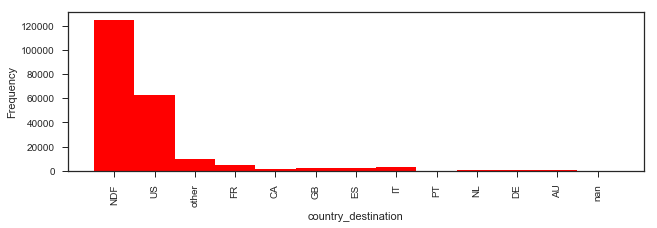

In [12]:
country_destination, count = cate_hist(df_all,'country_destination')    

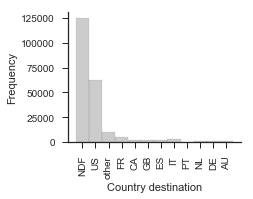

In [13]:
#Higher quality version of this histogram
save_on = True
df = df_train
col_name = 'country_destination'
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0)
fig = plt.figure(figsize=(4,3))
    #get list of category labels and count
categories = pd.unique(df[col_name].ravel())
count = [np.sum(df[col_name]==x) for x in categories]
    #generate the histogram
ax = fig.add_axes([.3,.3,.6,.6])
x = np.arange(len(categories))
y = count
width = 1.0
ax.bar(x,y,width,color=(0,0,0),alpha=0.2,edgecolor='k')
    #label the histogram
ax.set_xlabel('Country destination')
ax.set_ylabel('Frequency')
ax.set_xticks(x)
ax.set_xticklabels((categories))
plt.tick_params(direction = 'out')
plt.xticks(rotation = 90)
sns.despine()
if save_on:
    plt.savefig('country_destination_hist.png',dpi=600,edgecolor='k')

Print the proportions and standard error for each class.

In [14]:
p, se, categories = cate_prop_se(df, col_name)
print "category\tprop\t\tse"
for i in np.arange(len(categories)):
    print categories[i] + "\t\t" + str(np.round(p[i],4)) + "\t\t" + str(np.round(se[i],4))

category	prop		se
AU		0.0025		0.0001
CA		0.0067		0.0002
DE		0.005		0.0002
ES		0.0105		0.0002
FR		0.0235		0.0003
GB		0.0109		0.0002
IT		0.0133		0.0002
NDF		0.5835		0.0011
NL		0.0036		0.0001
PT		0.001		0.0001
US		0.2922		0.001
other		0.0473		0.0005


# Features

## 1. affiliate_channel
The type of paid marketing through which the user was refereced.  

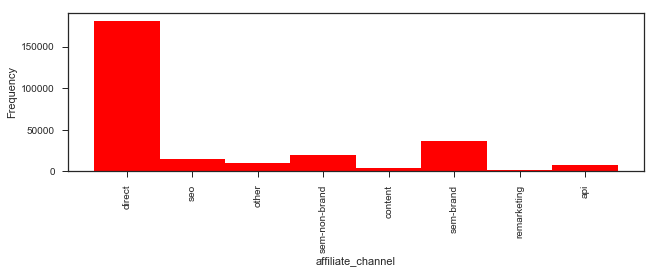

In [15]:
affiliate_channel, count = cate_hist(df_all,'affiliate_channel')    

In [16]:
check_missing(df_all, 'affiliate_channel')

0/275547 (0.00%) missing values for affiliate_channel.


(275547, 0)

## 2. Affiliate provider

The affiliate channel refers to the corporate partner through which the user was referenced.

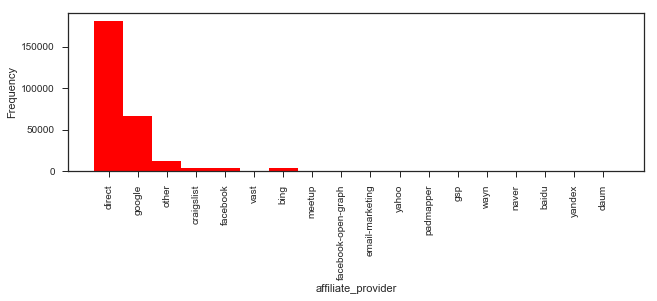

In [17]:
affiliate_provider, count = cate_hist(df_all,'affiliate_provider')    

In [18]:
check_missing(df_all, 'affiliate_provider')

0/275547 (0.00%) missing values for affiliate_provider.


(275547, 0)

## 3. Age
The age of the user in years.  A few aspects of note.  

(1) First, there several users that fall outside the range of the airbnb terms of service and are unlikely to be booking travel (e.g., 
users less than 14 or greater than 100 years of age.  We can treat these as if they are missing values rather than taking the value serious.  

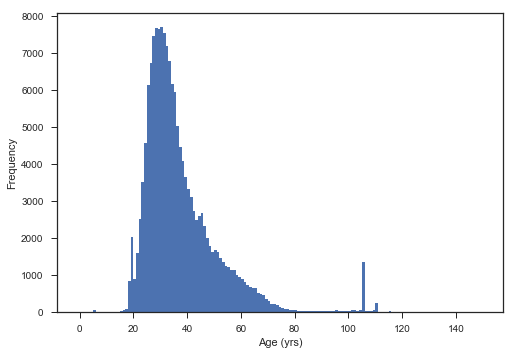

In [19]:
bins_=np.arange(-1,150+1)
fig, ax = plt.subplots()
plt.hist(df_all['age'][~pd.isnull(df_all['age'])],bins=bins_,range=None)
plt.xlabel('Age (yrs)')
plt.ylabel('Frequency') 

(2) Second, in addition to these users, there are many missing values; too many to simply discard.  If using logistic regression models, we can encode these as zeros and add a dummy variable.  If using decision trees, can encode these with some value well outside the normal range for easy categorization at a single node (e.g., -1 or 999999).  

In [20]:
check_missing(df_all,'age')

116866/275547 (42.41%) missing values for age.


(275547, 116866)

(3) We see substantial variation in country destination by age, suggesting that this is an informative variable for modeling.

/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


(30, 40)

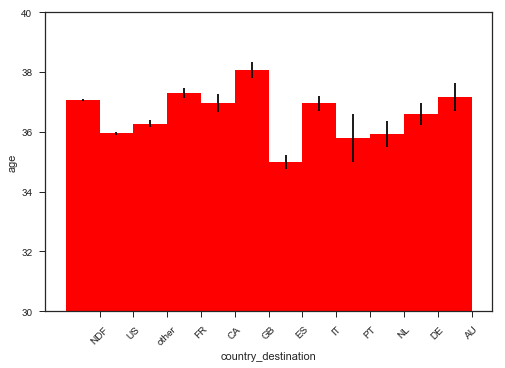

In [21]:
age = df_train.age.values
df_train['age'] = np.where(np.logical_or(age<14, age>100), np.nan, age)
#now let's get some descriptives about age for each category.
#mean, variance, std, se, max, min, range, p25, p50, p75
age_descriptives = cate_descriptives(df_train,'age','country_destination')
#plot
x = np.arange(len(age_descriptives['country_destination']))
y = age_descriptives['mean']
e = age_descriptives['se']
fig, ax = plt.subplots()
width = 1.0
ax.bar(x,y,width,color='r',yerr=e,error_kw=dict(ecolor='k'))
ax.set_xticks(x+width/2)
ax.set_xlabel('country_destination')
ax.set_ylabel('age')
ax.set_xticklabels(age_descriptives['country_destination'])
plt.tick_params(direction = 'out')
plt.xticks(rotation = 45)
plt.ylim([30,40])   


## 4. date_account_created

When was the account created?  Likely to contain information about travel (e.g., more travel in summer months, warmer destinations in colder months).

In [22]:
check_missing(df_all,'date_account_created')

0/275547 (0.00%) missing values for date_account_created.


(275547, 0)

We must format the date string into columns of year/month/day integers.

In [23]:
dac = df_all['date_account_created'].astype(str)    #convert to string
func = lambda x: list(map(int,x.split('-')))        #create a function handle that will 
                                                    #(1)split the string at '-'
                                                    #(2)convert to list of integers
dac = np.vstack(dac.apply(func))                    #Run func and concatenate rows to np array 
    #crate new columns in the data frame
df_all['dac_year']=dac[:,0]  #col for year
df_all['dac_month']=dac[:,1] #col for month
df_all['dac_day']=dac[:,2]   #col for day

There might also be useful information in the day of the week.  We can use the datetime.weekday function to convert the dates to days of the week (0=Monday to 6=Sunday) and weeks of the year (1-52).


In [24]:
    #use the datetime.weekday function to convert the dates to days of week (0=mon to 6=sun)
dac_wkday = [datetime.datetime(df_all['dac_year'][i],df_all['dac_month'][i],df_all['dac_day'][i]).weekday() for i in range(df_all.shape[0])]
df_all['dac_wkday']=dac_wkday
    #use datetime.date function to get week of year
dac_week = [datetime.date(df_all['dac_year'][i],df_all['dac_month'][i],df_all['dac_day'][i]).strftime("%U") for i in range(df_all.shape[0])]
df_all['dac_week'] = list(map(int,dac_week))

The line histogram of date_account_created indicates that accounts are growing rapidly over the years and also suggests peaks during the summer months.

/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60 but corresponding boolean dimension is 57


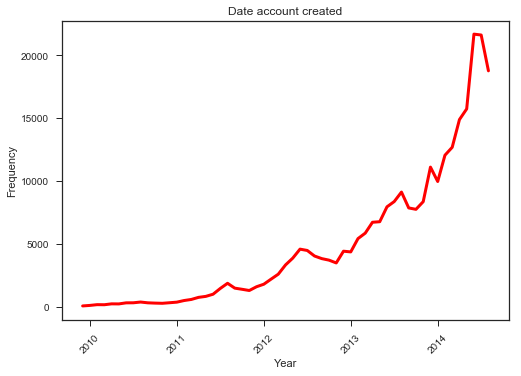

In [25]:
#plot histogram of date_account_created by month/yr
    #list of months and years
mo_list = np.arange(12)+1 #1-12
yr_list = np.arange(np.min(df_all['dac_year']),np.max(df_all['dac_year'])+1,1)#2010-2014
    #get frequency of each mo/yr combination
col_list = ['dac_year','dac_month']
mo_yr = df_all[col_list]
mo_yr_count = np.array(np.empty([len(mo_list)*len(yr_list),])*np.nan)
mo_idx = []
yr_idx = []
yr_grp_obj = mo_yr.groupby('dac_year') #created grouped df object by year
counter = 0
for yr_g, yr_grp in yr_grp_obj:
    mo_grp_obj = yr_grp.groupby('dac_month') #create grouped df object by month
    for mo_g, mo_grp in mo_grp_obj:
        mo_yr_count[counter]=int(mo_grp.shape[0])
        mo_idx.append(mo_g)
        yr_idx.append(yr_g)
        counter = counter + 1
    #assign to bins. accounts for months/yrs that may be skipped
mo_bins = np.tile(mo_list,len(yr_list))
yr_bins = np.tile(yr_list,(mo_list.shape[0],1)).T.reshape(len(mo_list)*len(yr_list),)
bin_count = np.empty([len(mo_bins),])*np.nan
bins = np.arange(len(mo_bins))
for i in np.arange(len(bin_count)):
    if np.sum(np.logical_and(mo_idx==mo_bins[i],yr_idx==yr_bins[i])):
        bin_count[i] = mo_yr_count[np.logical_and(mo_idx==mo_bins[i],yr_idx==yr_bins[i])]
    #plot
fig, ax = plt.subplots()
plt.plot(bins,bin_count, linewidth = 3.0, color='r')
plt.xticks(np.arange(1,12*len(yr_list)+1,12),yr_list,rotation=45)
plt.tick_params(direction='out')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Date account created')

## 5. date_first_booking
This variable is not available for the training set and so it is not useful for prediction.

In [26]:
df_all = df_all.drop(['date_first_booking'],axis=1)

## 6. first_affiliate_tracked

First marketing that the user signed up for.

In [27]:
check_missing(df_all,'first_affiliate_tracked')

6085/275547 (2.21%) missing values for first_affiliate_tracked.


(275547, 6085)

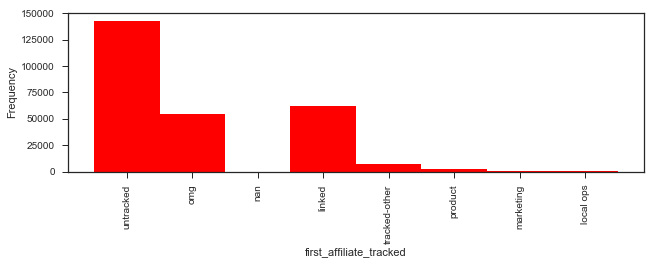

In [28]:
first_affiliate_tracked, count = cate_hist(df_all,'first_affiliate_tracked')

## 7. first_browser
Web browser used to set up the account.

In [29]:
check_missing(df_all,'first_browser')

0/275547 (0.00%) missing values for first_browser.


(275547, 0)

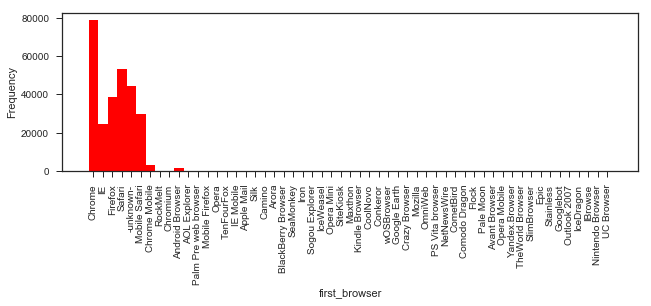

In [30]:
first_browser, count = cate_hist(df_all,'first_browser')

## 8. first_device_type
Device used to set up the account.

In [31]:
check_missing(df_all,'first_device_type')

0/275547 (0.00%) missing values for first_device_type.


(275547, 0)

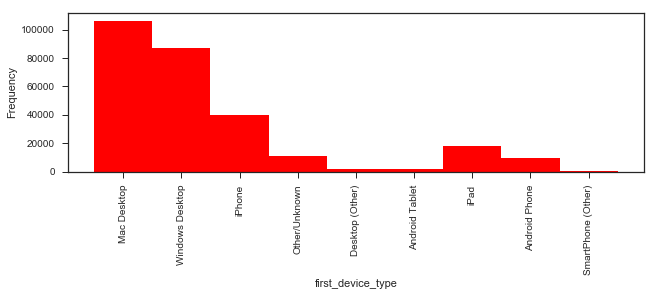

In [32]:
first_device_type, count = cate_hist(df_all,'first_device_type')

## 9. Gender
User gender. 

Although there are no null values, some entries are listed as "-unknown-" and must be recoded to missing values.

In [33]:
check_missing(df_all,'gender')

0/275547 (0.00%) missing values for gender.


(275547, 0)

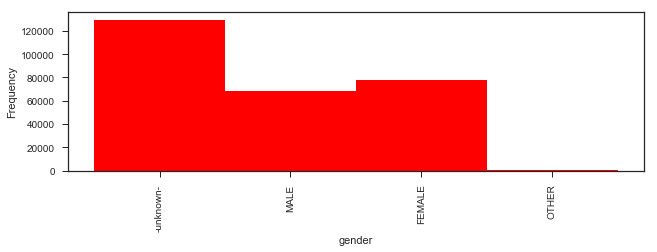

In [34]:
gender, count = cate_hist(df_all,'gender')

In [35]:
df_all['gender'] = df_all['gender'].replace('-unknown-',np.nan)

## 10. id
Unique identifier for each user.

Not useful for prediction.  Can be dropped.

In [36]:
df_all = df_all.drop(['id'], axis=1)

## 11. language
User language.  Some are listed as "-unknown-" and must be recoded to missing values.

In [37]:
check_missing(df_all,'language')

0/275547 (0.00%) missing values for language.


(275547, 0)

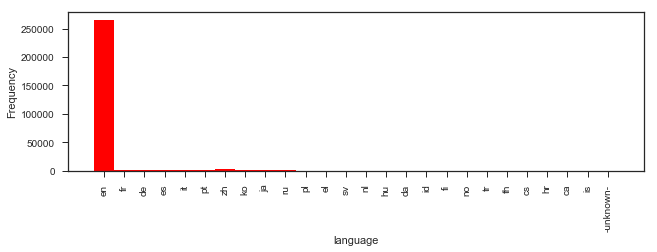

In [38]:
language, count = cate_hist(df_all,'language')

In [39]:
df_all['language'] = df_all['language'].replace('-unknown-',np.nan) 

## 12. signup_app
With which application did the user sign up.

In [40]:
check_missing(df_all,'signup_app')

0/275547 (0.00%) missing values for signup_app.


(275547, 0)

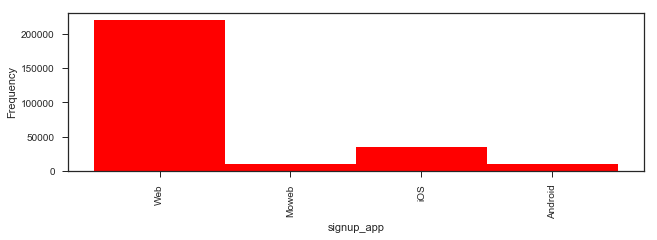

In [41]:
signup, count = cate_hist(df_all,'signup_app')

## 14. signup_method
Through which method did the user sign up (i.e., facebook, basic, google, or weibo).

In [42]:
check_missing(df_all,'signup_method')

0/275547 (0.00%) missing values for signup_method.


(275547, 0)

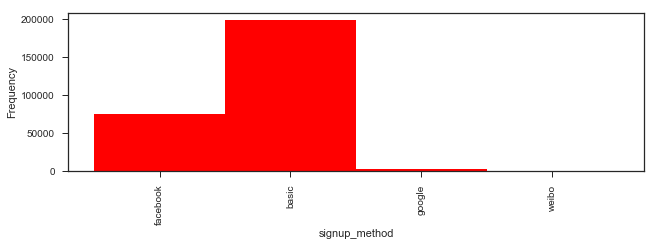

In [43]:
signup, count = cate_hist(df_all,'signup_method')

## 15. timestamp_first_active
When was the user first active on the account.  May differ from date_account_created because the user may create the account and use it at different times.

In [44]:
check_missing(df_all,'date_account_created')

0/275547 (0.00%) missing values for date_account_created.


(275547, 0)

Default format is YYYYMMDDHHMMSS (year, month, day, hour, minute, second).  Must be converted to df columns.

In [45]:
tfa=df_all.timestamp_first_active.astype(str) 
tfa=np.vstack(tfa.apply(lambda x: list(map(int, [x[0:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
    #create new columns
df_all['tfa_year']=tfa[:,0]
df_all['tfa_month']=tfa[:,1]
df_all['tfa_day']=tfa[:,2]
    #use datetime.weekday to creates days of week
tfa_wkday = [datetime.datetime(df_all['tfa_year'][i],df_all['tfa_month'][i],df_all['tfa_day'][i]).weekday() for i in range(df_all.shape[0])]
df_all['tfa_wkday']=tfa_wkday

## Signup flow
The page a user came to signup up from.

In [46]:
check_missing(df_all,'signup_flow')

0/275547 (0.00%) missing values for signup_flow.


(275547, 0)

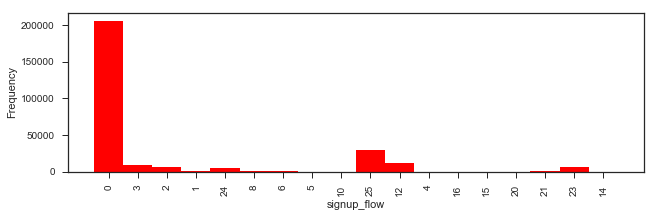

In [47]:
signup, count = cate_hist(df_all,'signup_flow')